In [2]:
from t_tools import *
from trpca import trpca
import numpy as np
import matplotlib.pyplot as plt
from skimage.exposure import rescale_intensity

In [3]:
#read in the data
arr_full_spectrum = np.load('clear.npy')

In [4]:
#we will use this to make it easier to view the data
def plot(image, dpi_=150):
    img = np.real(image.copy())
    for b in range(image.shape[2]):
        tmp = image[:,:,b]
        pl, pu = np.percentile(tmp[np.isfinite(tmp)], (1, 99)) # 1-99% cut-off
        img[:,:,b] = rescale_intensity(image[:,:,b], in_range=(pl, pu), out_range=(0., 1.))

    plt.figure(dpi = dpi_)
    plt.imshow(img, interpolation='bilinear')
    plt.tick_params(axis='both', which='both', bottom= False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
    plt.tight_layout()

In [5]:
#since satellite images capture more than just red, green and blue (such as infrared
#or ultraviolet), we have 10 values for each pixel location, where a normal image would have 3
arr_full_spectrum.shape

(410, 565, 10)

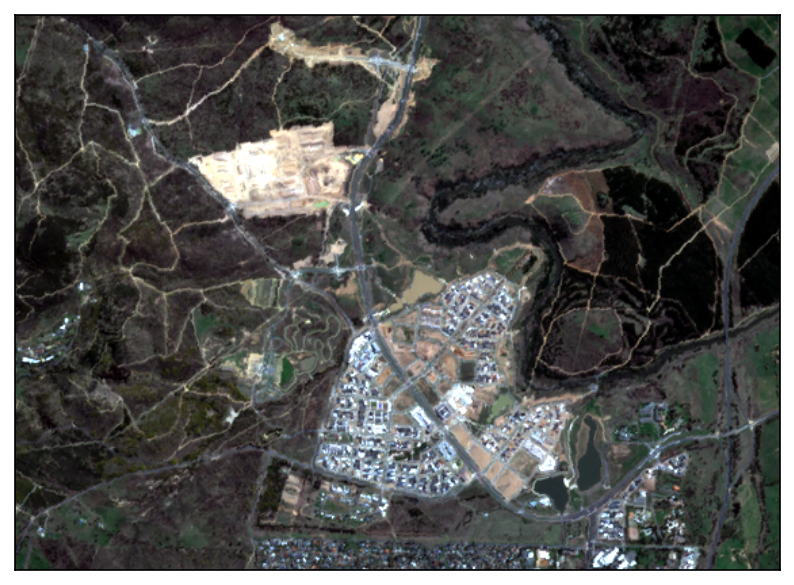

In [6]:
#we can look at the the red, green and blue, but we are ignoring data
plot(arr_full_spectrum[:, :, [2,1,0]])

C:\ProgramData\Anaconda3\lib\site-packages\skimage\exposure\exposure.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  imin, imax = map(float, intensity_range(image, in_range))
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


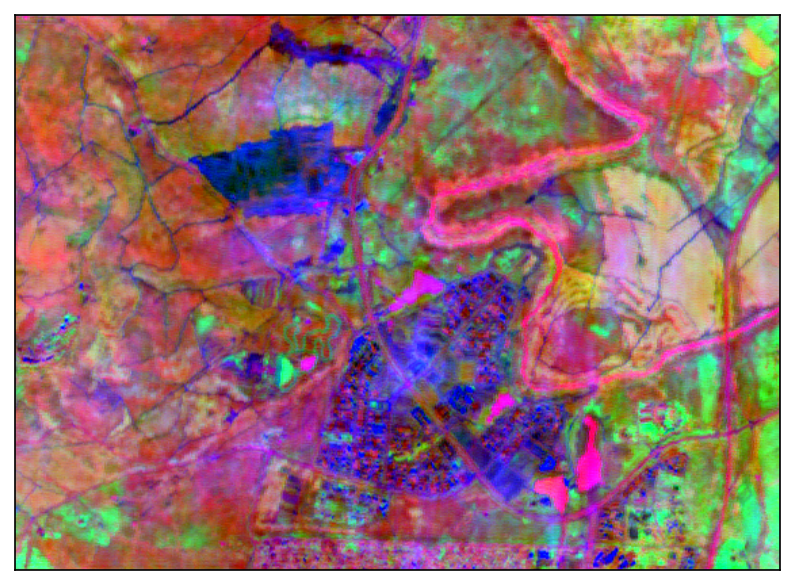

In [7]:
#instead of ignoring this extra information, we can project 10 dimensions into three
#here that is done using the tensor singular value decomposition
arr_full_spectrum = np.swapaxes(arr_full_spectrum,0,2)
U, S, V = t_SVD(arr_full_spectrum)
U_T = t_transpose(U)
U_T_reduced = U_T[[0,1,2],:,:]
projection_t = t_prod(U_T_reduced, arr_full_spectrum)
projection_t = np.swapaxes(projection_t,0,2)
plot(projection_t)

In [8]:
#to get an idea of how effective the rank-3 projection above was, we
#can copmare a rank three approximation to to the original
low_rank = np.zeros(arr_full_spectrum.shape, dtype = 'complex')
rank = 3
for i in range(rank):
    low_rank += t_prod(t_prod(U[:, i:i + 1,:], S[i:i + 1, i:i + 1, :]), V[i:i + 1, :, :])
np.linalg.norm(low_rank - arr_full_spectrum)/np.linalg.norm(arr_full_spectrum)

0.034278075500315856

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


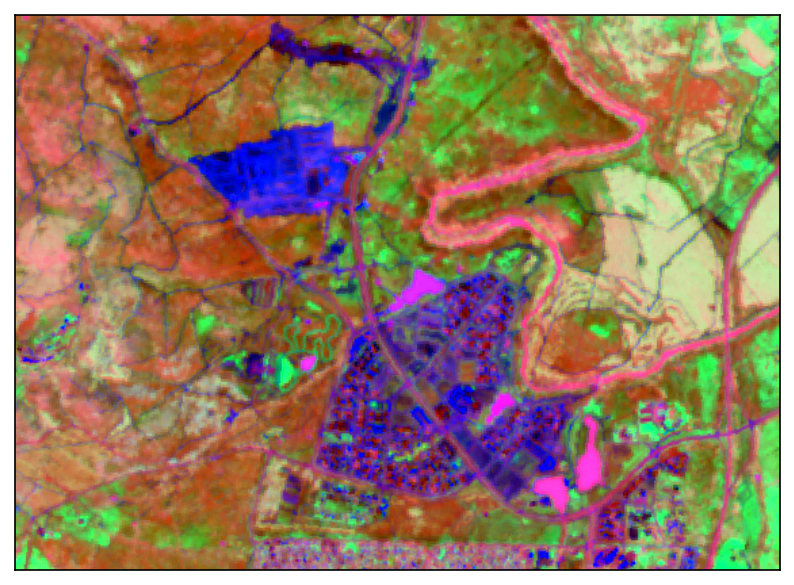

In [9]:
#here can project 10 dimensions into three by flattening the image
#and using the matrix singular value decomposition
flat = np.reshape(arr_full_spectrum, (10, 565*410))
u, s, v = np.linalg.svd(flat, full_matrices = False)
u_t = u.T
u_t_reduced = u_t[0:3,:]
projected_flat = u_t_reduced @ flat
unflatten =  np.reshape(projected_flat, (3, 565, 410))
unflatten = np.swapaxes(unflatten,0,2)
plot(unflatten)

In [10]:
#to get an idea of how effective this rank-3 projection was, we
#copmare it to to the original
s[3:] = 0
np.linalg.norm(u @ np.diag(s) @ v - flat) / np.linalg.norm(flat)

0.04699915